In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop, SGD
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from tensorflow import keras

In [ ]:
TRAINING_PATH = "/content/drive/Shareddrives/1:1_Maahum_Jahangir/Dataset/Train"
VALIDATION_PATH = "/content/drive/Shareddrives/1:1_Maahum_Jahangir/Dataset/Validation"

In [ ]:
def create_model(base_model, num_classes):
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(100,activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=True)(x)
  preds = tf.keras.layers.Dense(num_classes,activation='softmax', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=False)(x)
  model = Model(inputs=base_model.input,outputs=preds)
  return model

In [ ]:
# optimizer --> math function that updates parameters based on current/past performance to increase accuracy
# goes to tensorflow and calls optimizer function chosen later
def get_optimizer(optimizer_name, learning_rate):
  print('Selected Optimizer', optimizer_name)
  switcher = {
        'Adadelta': Adadelta(learning_rate=learning_rate),
        'Adagrad': Adagrad(learning_rate=learning_rate),
        'Adam': Adam(learning_rate=learning_rate),
        'Adamax': Adamax(learning_rate=learning_rate),
        'FTRL': Ftrl(learning_rate=learning_rate),
        'NAdam': Nadam(learning_rate=learning_rate),
        'RMSprop': RMSprop(learning_rate=learning_rate),
        'Gradient Descent': SGD(learning_rate=learning_rate)
  }
  return switcher.get(optimizer_name, Adam(learning_rate=learning_rate))

In [ ]:
# building the model

epochs = 10 #<-- increase for higher accuracy
base_learning_rate = 0.05 #decrease for different results; use excel sheet to note down validation accuracy from each change to learning rate and epochs
optimizer = 'Adam'
BATCH_SIZE = 32 # images at a time

IMG_SIZE = (224, 224)

# Create the data generation pipeline for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # train_datagen --> holds function that gets dataset + preprocesses
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAINING_PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                )
print(validation_generator.class_indices.keys())
# Download the model, valid alpha values [0.25,0.35,0.5,0.75,1]
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', alpha=0.35)
for layer in base_model.layers:
    layer.trainable=False

num_classes = 2

# Create the base model
model = create_model(base_model,num_classes)

print(len(base_model.layers))

model.compile(optimizer = get_optimizer(optimizer_name=optimizer,learning_rate=base_learning_rate),loss='CategoricalCrossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

step_size_train = train_generator.n//train_generator.batch_size
history_fine = model.fit(train_generator,
                        epochs=epochs,
                        validation_data = validation_generator,
                        verbose=1)

model.save('/content/drive/Shareddrives/1:1_Maahum_Jahangir/Best Model/model.h5')
# https://drive.google.com/drive/folders/1WAgF60tGOxl5SA9EYkSaWSKfQbEAuzAw?usp=drive_link

Found 113 images belonging to 2 classes.
Found 11 images belonging to 2 classes.
dict_keys(['abnormal', 'normal'])
154
Selected Optimizer Adam
Epoch 1/10
4/4 [==============================] - 9s 991ms/step - loss: 9.4437 - accuracy: 0.5575 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 3s 843ms/step - loss: 0.2495 - accuracy: 0.9381 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 2s 589ms/step - loss: 0.1778 - accuracy: 0.9646 - val_loss: 2.2448e-04 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 2s 439ms/step - loss: 0.0424 - accuracy: 0.9912 - val_loss: 0.1794 - val_accuracy: 0.9091
Epoch 5/10
4/4 [==============================] - 2s 439ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 2s 445ms/step - loss: 0.2914 - accuracy: 0.9735 - val_loss: 0.5963 - val_accuracy: 0.9091
Epoch 7/10
4/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


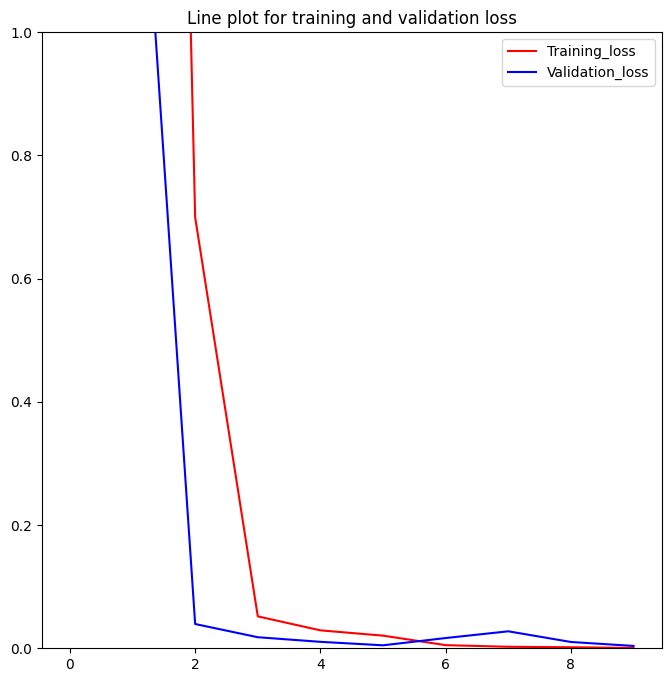

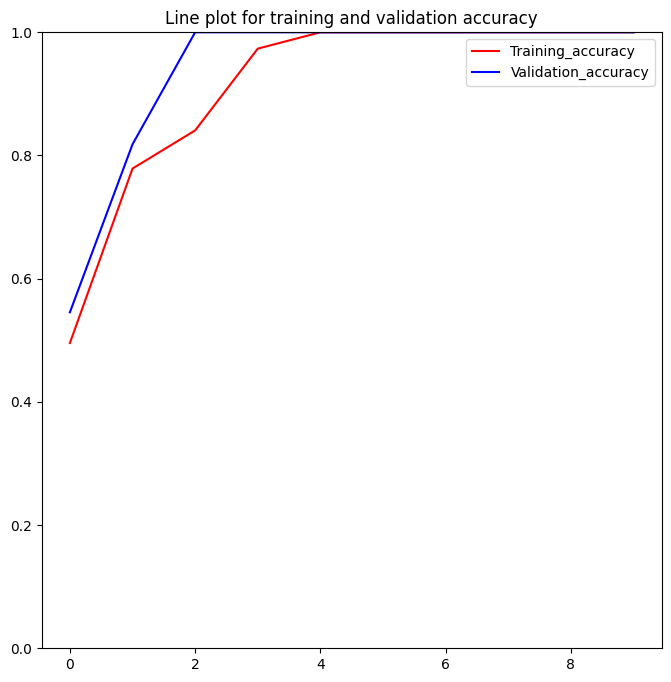

In [ ]:
def visualization():
  import pandas as pd
  df = pd.DataFrame(history_fine.history)
  # Loss plots:
  plt.figure(figsize = (8,8)) # empty 8x8 structure for plot
  plt.plot(df['loss'], color='red', label = "Training_loss") # creating plot for training
  plt.plot(df['val_loss'], color='blue', label = "Validation_loss")
  plt.legend(["Training_loss", "Validation_loss"], loc = "best")
  plt.title("Line plot for training and validation loss")
  plt.ylim(0, 1)

  plt.figure(figsize = (8,8)) # empty 8x8 structure for plot
  plt.plot(df['accuracy'], color='red', label = "Training_accuracy") # creating plot for training
  plt.plot(df['val_accuracy'], color='blue', label = "Validation_accuracy")
  plt.legend(["Training_accuracy", "Validation_accuracy"], loc = "best")
  plt.title("Line plot for training and validation accuracy")
  plt.ylim(0, 1)

visualization()

In [ ]:
# Calculating best model accuracy
accuracy = history_fine.history['accuracy']
val_accuracy = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

print('Training Accuracy: ', accuracy)
print('Validation Accuracy: ', val_accuracy)
print('Training Loss: ', loss)
print('Validation Loss: ', val_loss)

# Store best model accuracy
best_model_accuracy = history_fine.history['val_accuracy'][np.argmin(history_fine.history['val_loss'])]
print('Best Model Accuracy: ', best_model_accuracy)

Training Accuracy:  [0.4955752193927765, 0.778761088848114, 0.8407079577445984, 0.9734513163566589, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy:  [0.5454545617103577, 0.8181818127632141, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Training Loss:  [22.319612503051758, 5.030715465545654, 0.6994997262954712, 0.051805101335048676, 0.029099944978952408, 0.020507605746388435, 0.0050803255289793015, 0.002430335618555546, 0.0016964655369520187, 0.0004923482774756849]
Validation Loss:  [14.275854110717773, 1.5501694679260254, 0.03939970210194588, 0.01794189214706421, 0.010456628166139126, 0.004816463682800531, 0.01661686785519123, 0.02754920907318592, 0.010234110057353973, 0.0038036371115595102]
Best Model Accuracy:  1.0


In [ ]:
# Generate labels (abnormal and normal)
def separate_labels(generator):
  x_validation = []
  y_validation = []
  num_seen = 0

  for x, labels in generator:
      x_validation.append(x)
      y_validation.append([np.argmax(label) for label in labels])
      num_seen += len(x)
      if num_seen == generator.n: break

  x_validation = np.concatenate(x_validation)
  y_validation = np.concatenate(y_validation)
  return x_validation, y_validation

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/Shareddrives/1:1_Maahum_Jahangir/Best Model/model.h5")

In [ ]:
source_path = "/content/drive/Shareddrives/1:1_Maahum_Jahangir/Dataset/Test"
import os
# list of files in test folder
dictionary_labels = [file for file in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, file))] # list comprehension
dictionary_labels.sort()

# enumerate and turn into dictionary --> {0: "abnormal", 1: "normal"}
dict_labels = dict(enumerate(dictionary_labels))

dict_labels

{0: 'abnormal', 1: 'normal'}

In [ ]:
# create list of images (train and test)

# storing indexes of images
directory_contents = []

for index in range(0,len(dict_labels)):
  directory_contents.append(dict_labels[index])

print(directory_contents)

# list of files
list_files = []

# Find all the files
for folder_name in directory_contents:
  files_list = os.listdir(os.path.join(source_path, folder_name))
  list_files.append(files_list)

print(list_files)

['abnormal', 'normal']
[['g13.jpg', 's12.jpg', 'm3.jpg', 's2.jpg', 'g22.jpg', 'g8.jpg', 'g20.jpg'], ['021 (1).jpg', '022.jpg', '024 (1).jpg', '033.jpg', '033 (1).jpg', '007 (1).jpg']]


In [ ]:
# Confusion Matrix Method 1
from numpy.core.fromnumeric import argmax
from sklearn.metrics import ConfusionMatrixDisplay

x_validation, y_validation = separate_labels(validation_generator)
y_pred = model.predict(x_validation, batch_size=BATCH_SIZE)
predictions = np.apply_along_axis(argmax, 1, y_pred)
display_labels = validation_generator.class_indices.keys()

1/1 [==============================] - 2s 2s/step


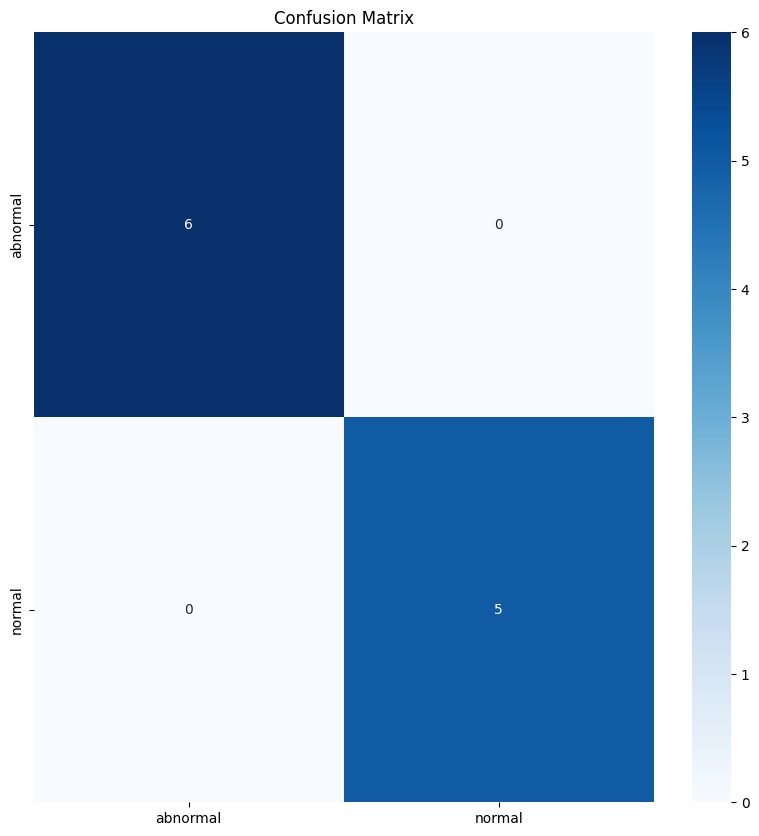

In [ ]:
# Confusion Matrix Method 2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(y_validation, predictions), annot = True, fmt = 'g', cmap = "Blues",xticklabels=display_labels, yticklabels=display_labels)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Print metrics
print(classification_report(y_validation, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



In [ ]:
# Testing on an image
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/Shareddrives/1:1_Maahum_Jahangir/Dataset/Test/abnormal/g13.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction)

1/1 [==============================] - 0s 64ms/step
[[1.0000000e+00 6.9459986e-11]]


In [ ]:
# Prediction and labels lists

from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

category_count = 0
label_list = []
predictions_list = []
y_score = [] # score of each prediction

for categories in list_files:
  label_temp = np.ones((len(categories))).astype(int) * category_count
  print(label_temp)

# Add it to existing labels
  label_list.extend(label_temp)
  for file_name in categories:
    # test image file
    img_path = source_path + '/' + directory_contents[category_count] + '/' + file_name
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = loaded_model.predict(img_preprocessed)
    y_score.append(prediction)
    # Save the index of maximum probability
    predictions_list.append(np.argmax(prediction))
  category_count += 1

[0 0 0 0 0 0 0]
1/1 [==============================] - 0s 36ms/step
[1 1 1 1 1 1]
1/1 [==============================] - 0s 37ms/step


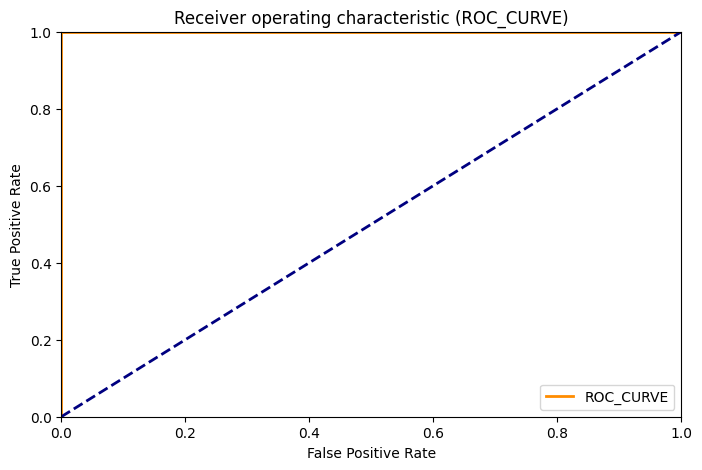

In [ ]:
probs = np.array([i[0] for i in y_score])
#ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# 0s are negative and 1s are positive
fpr, tpr, _ = roc_curve(label_list, probs[:,1])

plt.figure(figsize = (8,5))
plt.plot(fpr,tpr, label = "ROC_CURVE", lw = 2, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC_CURVE)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.legend(loc = 'lower right')
plt.show()

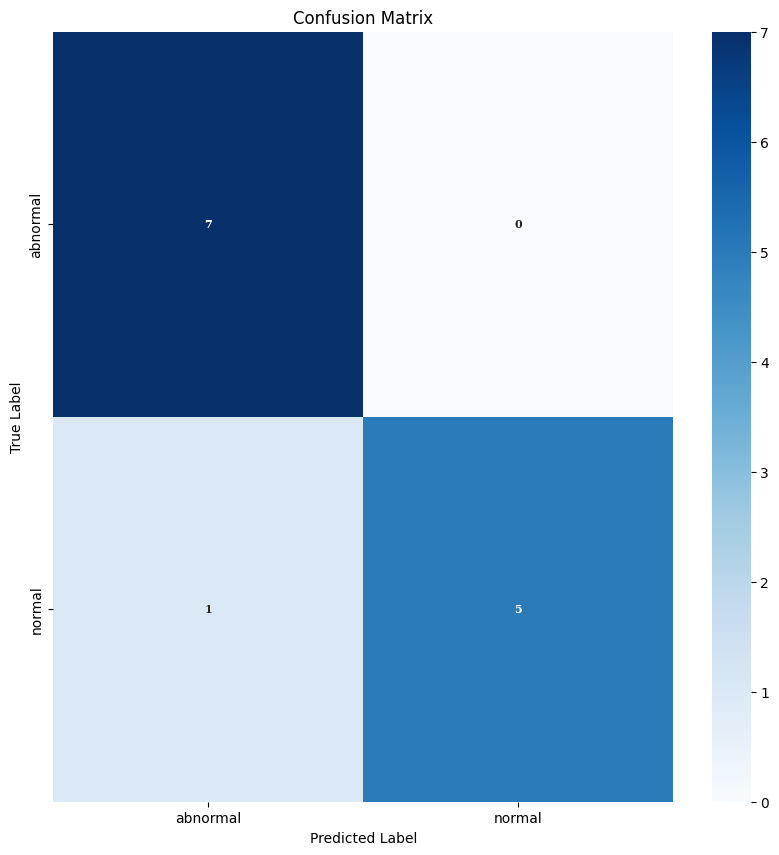

In [ ]:
# Confusion Matrix for Test Data
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
display_labels = sorted(directory_contents)
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(label_list,predictions_list),
            annot = True,
            fmt = 'g',
            cmap = "Blues",
            xticklabels=display_labels,
            yticklabels = display_labels,
            annot_kws={
                'fontsize': 8,
                'fontweight': 'bold',
                'fontfamily': 'serif'
            })
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#ConfusionMatrixDisplay.from_predictions(label, predictions, display_labels=display_labels, cmap="binary")
plt.show()

In [ ]:
# Classification reports for test
from sklearn.metrics import classification_report
print(classification_report(label_list,predictions_list))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.83      0.91         6

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13



In [ ]:
#precision score and recall score
from sklearn.metrics import precision_score, recall_score
import pandas as pd
precision = precision_score(label_list, predictions_list, average = None)
recall = recall_score(label_list,predictions_list, average = None)

#creating the dataframe
df = pd.DataFrame()
list_dict = []
dict1 = {}
dict2 = {}
for num in range(len(recall)):
  dict1[dict_labels[num]] = precision[num]
  dict2[dict_labels[num]] = recall[num]
list_dict.extend([dict1,dict2])
df_metrics = df.append(list_dict, ignore_index = False)
df_metrics['metrics'] = ['precision','recall']
df_metrics.set_index('metrics', inplace = True)
df_metrics.to_csv("precision_recall.csv", index = True)
print("CSV Saved")

CSV Saved


<ipython-input-107-0892958c9b79>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df.append(list_dict, ignore_index = False)
